# HAR CNN + LSTM training 

In [1]:
# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
X_train, labels_train, list_ch_train = read_data(data_path="./data/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="./data/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [3]:
# Standardize
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train,
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [6]:
# Imports
import tensorflow as tf

/Users/isabelmetzger/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Hyperparameters

In [7]:
lstm_size = 27         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001  # Learning rate (default is 0.001)
epochs = 1000

# Fixed
n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [8]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layer(s)

Questions: 
* Should we use a different activation? Like tf.nn.tanh?
* Should we use pooling? average or max?

In [9]:
# Convolutional layers
with graph.as_default():
    # (batch, 128, 9) --> (batch, 128, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    n_ch = n_channels *2
    

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Now, pass to LSTM cells

In [10]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(conv1, [1,0,2]) # reshape into (seq_len, batch, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_ch]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Define forward pass and cost function:

In [11]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### Train the network

In [12]:
if (os.path.exists('checkpoints-crnn') == False):
    !mkdir checkpoints-crnn

In [13]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%25 == 0):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-crnn/har.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 1.783229 Train acc: 0.183333
Epoch: 1/1000 Iteration: 10 Train loss: 1.769416 Train acc: 0.256667
Epoch: 1/1000 Iteration: 15 Train loss: 1.767461 Train acc: 0.228333
Epoch: 2/1000 Iteration: 20 Train loss: 1.759298 Train acc: 0.223333
Epoch: 2/1000 Iteration: 25 Train loss: 1.759661 Train acc: 0.230000
Epoch: 2/1000 Iteration: 25 Validation loss: 1.740980 Validation acc: 0.309444
Epoch: 3/1000 Iteration: 30 Train loss: 1.747808 Train acc: 0.238333
Epoch: 3/1000 Iteration: 35 Train loss: 1.747404 Train acc: 0.263333
Epoch: 4/1000 Iteration: 40 Train loss: 1.733186 Train acc: 0.275000
Epoch: 4/1000 Iteration: 45 Train loss: 1.726025 Train acc: 0.265000
Epoch: 5/1000 Iteration: 50 Train loss: 1.700659 Train acc: 0.326667
Epoch: 5/1000 Iteration: 50 Validation loss: 1.696809 Validation acc: 0.373889
Epoch: 6/1000 Iteration: 55 Train loss: 1.701226 Train acc: 0.303333
Epoch: 6/1000 Iteration: 60 Train loss: 1.686381 Train acc: 0.355000
Epoch: 7/1000 I

Epoch: 53/1000 Iteration: 480 Train loss: 0.807085 Train acc: 0.720000
Epoch: 53/1000 Iteration: 485 Train loss: 0.769326 Train acc: 0.761667
Epoch: 54/1000 Iteration: 490 Train loss: 0.782829 Train acc: 0.731667
Epoch: 54/1000 Iteration: 495 Train loss: 0.827645 Train acc: 0.716667
Epoch: 55/1000 Iteration: 500 Train loss: 0.759955 Train acc: 0.735000
Epoch: 55/1000 Iteration: 500 Validation loss: 0.650087 Validation acc: 0.881667
Epoch: 56/1000 Iteration: 505 Train loss: 0.746744 Train acc: 0.743333
Epoch: 56/1000 Iteration: 510 Train loss: 0.731780 Train acc: 0.728333
Epoch: 57/1000 Iteration: 515 Train loss: 0.735481 Train acc: 0.745000
Epoch: 57/1000 Iteration: 520 Train loss: 0.735364 Train acc: 0.748333
Epoch: 58/1000 Iteration: 525 Train loss: 0.751692 Train acc: 0.726667
Epoch: 58/1000 Iteration: 525 Validation loss: 0.603431 Validation acc: 0.890556
Epoch: 58/1000 Iteration: 530 Train loss: 0.716574 Train acc: 0.771667
Epoch: 59/1000 Iteration: 535 Train loss: 0.715252 Train 

Epoch: 105/1000 Iteration: 950 Validation loss: 0.260874 Validation acc: 0.946111
Epoch: 106/1000 Iteration: 955 Train loss: 0.347818 Train acc: 0.921667
Epoch: 106/1000 Iteration: 960 Train loss: 0.355257 Train acc: 0.923333
Epoch: 107/1000 Iteration: 965 Train loss: 0.352402 Train acc: 0.923333
Epoch: 107/1000 Iteration: 970 Train loss: 0.385268 Train acc: 0.908333
Epoch: 108/1000 Iteration: 975 Train loss: 0.384105 Train acc: 0.916667
Epoch: 108/1000 Iteration: 975 Validation loss: 0.253516 Validation acc: 0.947222
Epoch: 108/1000 Iteration: 980 Train loss: 0.321184 Train acc: 0.928333
Epoch: 109/1000 Iteration: 985 Train loss: 0.399836 Train acc: 0.896667
Epoch: 109/1000 Iteration: 990 Train loss: 0.358393 Train acc: 0.921667
Epoch: 110/1000 Iteration: 995 Train loss: 0.362250 Train acc: 0.923333
Epoch: 111/1000 Iteration: 1000 Train loss: 0.341208 Train acc: 0.933333
Epoch: 111/1000 Iteration: 1000 Validation loss: 0.248396 Validation acc: 0.946667
Epoch: 111/1000 Iteration: 1005 

Epoch: 156/1000 Iteration: 1410 Train loss: 0.266015 Train acc: 0.943333
Epoch: 157/1000 Iteration: 1415 Train loss: 0.253896 Train acc: 0.945000
Epoch: 157/1000 Iteration: 1420 Train loss: 0.270266 Train acc: 0.941667
Epoch: 158/1000 Iteration: 1425 Train loss: 0.284907 Train acc: 0.931667
Epoch: 158/1000 Iteration: 1425 Validation loss: 0.177510 Validation acc: 0.953333
Epoch: 158/1000 Iteration: 1430 Train loss: 0.230559 Train acc: 0.956667
Epoch: 159/1000 Iteration: 1435 Train loss: 0.319543 Train acc: 0.921667
Epoch: 159/1000 Iteration: 1440 Train loss: 0.281574 Train acc: 0.933333
Epoch: 160/1000 Iteration: 1445 Train loss: 0.246585 Train acc: 0.953333
Epoch: 161/1000 Iteration: 1450 Train loss: 0.243951 Train acc: 0.948333
Epoch: 161/1000 Iteration: 1450 Validation loss: 0.184273 Validation acc: 0.951111
Epoch: 161/1000 Iteration: 1455 Train loss: 0.234978 Train acc: 0.960000
Epoch: 162/1000 Iteration: 1460 Train loss: 0.252735 Train acc: 0.948333
Epoch: 162/1000 Iteration: 1465

Epoch: 207/1000 Iteration: 1870 Train loss: 0.221836 Train acc: 0.946667
Epoch: 208/1000 Iteration: 1875 Train loss: 0.227533 Train acc: 0.948333
Epoch: 208/1000 Iteration: 1875 Validation loss: 0.145477 Validation acc: 0.955000
Epoch: 208/1000 Iteration: 1880 Train loss: 0.201443 Train acc: 0.960000
Epoch: 209/1000 Iteration: 1885 Train loss: 0.244853 Train acc: 0.933333
Epoch: 209/1000 Iteration: 1890 Train loss: 0.240282 Train acc: 0.945000
Epoch: 210/1000 Iteration: 1895 Train loss: 0.221544 Train acc: 0.951667
Epoch: 211/1000 Iteration: 1900 Train loss: 0.207439 Train acc: 0.955000
Epoch: 211/1000 Iteration: 1900 Validation loss: 0.144164 Validation acc: 0.954444
Epoch: 211/1000 Iteration: 1905 Train loss: 0.196501 Train acc: 0.950000
Epoch: 212/1000 Iteration: 1910 Train loss: 0.211787 Train acc: 0.950000
Epoch: 212/1000 Iteration: 1915 Train loss: 0.218791 Train acc: 0.943333
Epoch: 213/1000 Iteration: 1920 Train loss: 0.235666 Train acc: 0.945000
Epoch: 213/1000 Iteration: 1925

Epoch: 258/1000 Iteration: 2325 Validation loss: 0.131082 Validation acc: 0.957222
Epoch: 258/1000 Iteration: 2330 Train loss: 0.158983 Train acc: 0.970000
Epoch: 259/1000 Iteration: 2335 Train loss: 0.206174 Train acc: 0.936667
Epoch: 259/1000 Iteration: 2340 Train loss: 0.212666 Train acc: 0.946667
Epoch: 260/1000 Iteration: 2345 Train loss: 0.207952 Train acc: 0.940000
Epoch: 261/1000 Iteration: 2350 Train loss: 0.177715 Train acc: 0.953333
Epoch: 261/1000 Iteration: 2350 Validation loss: 0.128847 Validation acc: 0.958333
Epoch: 261/1000 Iteration: 2355 Train loss: 0.189866 Train acc: 0.951667
Epoch: 262/1000 Iteration: 2360 Train loss: 0.203896 Train acc: 0.948333
Epoch: 262/1000 Iteration: 2365 Train loss: 0.208022 Train acc: 0.946667
Epoch: 263/1000 Iteration: 2370 Train loss: 0.220450 Train acc: 0.943333
Epoch: 263/1000 Iteration: 2375 Train loss: 0.152348 Train acc: 0.965000
Epoch: 263/1000 Iteration: 2375 Validation loss: 0.130732 Validation acc: 0.957778
Epoch: 264/1000 Itera

Epoch: 309/1000 Iteration: 2785 Train loss: 0.206822 Train acc: 0.926667
Epoch: 309/1000 Iteration: 2790 Train loss: 0.212547 Train acc: 0.950000
Epoch: 310/1000 Iteration: 2795 Train loss: 0.170630 Train acc: 0.955000
Epoch: 311/1000 Iteration: 2800 Train loss: 0.163065 Train acc: 0.958333
Epoch: 311/1000 Iteration: 2800 Validation loss: 0.122834 Validation acc: 0.958333
Epoch: 311/1000 Iteration: 2805 Train loss: 0.173113 Train acc: 0.958333
Epoch: 312/1000 Iteration: 2810 Train loss: 0.170967 Train acc: 0.946667
Epoch: 312/1000 Iteration: 2815 Train loss: 0.187338 Train acc: 0.950000
Epoch: 313/1000 Iteration: 2820 Train loss: 0.207094 Train acc: 0.945000
Epoch: 313/1000 Iteration: 2825 Train loss: 0.148868 Train acc: 0.961667
Epoch: 313/1000 Iteration: 2825 Validation loss: 0.121726 Validation acc: 0.958333
Epoch: 314/1000 Iteration: 2830 Train loss: 0.208555 Train acc: 0.935000
Epoch: 314/1000 Iteration: 2835 Train loss: 0.203833 Train acc: 0.945000
Epoch: 315/1000 Iteration: 2840

Epoch: 360/1000 Iteration: 3245 Train loss: 0.158742 Train acc: 0.955000
Epoch: 361/1000 Iteration: 3250 Train loss: 0.161754 Train acc: 0.945000
Epoch: 361/1000 Iteration: 3250 Validation loss: 0.117767 Validation acc: 0.958333
Epoch: 361/1000 Iteration: 3255 Train loss: 0.136461 Train acc: 0.955000
Epoch: 362/1000 Iteration: 3260 Train loss: 0.172451 Train acc: 0.956667
Epoch: 362/1000 Iteration: 3265 Train loss: 0.162345 Train acc: 0.958333
Epoch: 363/1000 Iteration: 3270 Train loss: 0.159389 Train acc: 0.953333
Epoch: 363/1000 Iteration: 3275 Train loss: 0.133768 Train acc: 0.970000
Epoch: 363/1000 Iteration: 3275 Validation loss: 0.118467 Validation acc: 0.958333
Epoch: 364/1000 Iteration: 3280 Train loss: 0.183561 Train acc: 0.936667
Epoch: 364/1000 Iteration: 3285 Train loss: 0.187117 Train acc: 0.941667
Epoch: 365/1000 Iteration: 3290 Train loss: 0.151670 Train acc: 0.963333
Epoch: 366/1000 Iteration: 3295 Train loss: 0.150313 Train acc: 0.960000
Epoch: 366/1000 Iteration: 3300

Epoch: 411/1000 Iteration: 3700 Validation loss: 0.111112 Validation acc: 0.959444
Epoch: 411/1000 Iteration: 3705 Train loss: 0.136527 Train acc: 0.963333
Epoch: 412/1000 Iteration: 3710 Train loss: 0.153494 Train acc: 0.960000
Epoch: 412/1000 Iteration: 3715 Train loss: 0.157477 Train acc: 0.958333
Epoch: 413/1000 Iteration: 3720 Train loss: 0.146573 Train acc: 0.953333
Epoch: 413/1000 Iteration: 3725 Train loss: 0.126846 Train acc: 0.968333
Epoch: 413/1000 Iteration: 3725 Validation loss: 0.110878 Validation acc: 0.961111
Epoch: 414/1000 Iteration: 3730 Train loss: 0.182034 Train acc: 0.938333
Epoch: 414/1000 Iteration: 3735 Train loss: 0.169767 Train acc: 0.950000
Epoch: 415/1000 Iteration: 3740 Train loss: 0.130020 Train acc: 0.970000
Epoch: 416/1000 Iteration: 3745 Train loss: 0.153272 Train acc: 0.953333
Epoch: 416/1000 Iteration: 3750 Train loss: 0.146469 Train acc: 0.961667
Epoch: 416/1000 Iteration: 3750 Validation loss: 0.111539 Validation acc: 0.960556
Epoch: 417/1000 Itera

Epoch: 462/1000 Iteration: 4160 Train loss: 0.153180 Train acc: 0.956667
Epoch: 462/1000 Iteration: 4165 Train loss: 0.138908 Train acc: 0.951667
Epoch: 463/1000 Iteration: 4170 Train loss: 0.177674 Train acc: 0.951667
Epoch: 463/1000 Iteration: 4175 Train loss: 0.123577 Train acc: 0.963333
Epoch: 463/1000 Iteration: 4175 Validation loss: 0.111983 Validation acc: 0.961667
Epoch: 464/1000 Iteration: 4180 Train loss: 0.186988 Train acc: 0.930000
Epoch: 464/1000 Iteration: 4185 Train loss: 0.146455 Train acc: 0.951667
Epoch: 465/1000 Iteration: 4190 Train loss: 0.139341 Train acc: 0.955000
Epoch: 466/1000 Iteration: 4195 Train loss: 0.139327 Train acc: 0.951667
Epoch: 466/1000 Iteration: 4200 Train loss: 0.127271 Train acc: 0.966667
Epoch: 466/1000 Iteration: 4200 Validation loss: 0.110189 Validation acc: 0.961111
Epoch: 467/1000 Iteration: 4205 Train loss: 0.138085 Train acc: 0.961667
Epoch: 467/1000 Iteration: 4210 Train loss: 0.148300 Train acc: 0.956667
Epoch: 468/1000 Iteration: 4215

Epoch: 513/1000 Iteration: 4620 Train loss: 0.155696 Train acc: 0.950000
Epoch: 513/1000 Iteration: 4625 Train loss: 0.111220 Train acc: 0.966667
Epoch: 513/1000 Iteration: 4625 Validation loss: 0.107566 Validation acc: 0.960000
Epoch: 514/1000 Iteration: 4630 Train loss: 0.171993 Train acc: 0.936667
Epoch: 514/1000 Iteration: 4635 Train loss: 0.134389 Train acc: 0.955000
Epoch: 515/1000 Iteration: 4640 Train loss: 0.123905 Train acc: 0.965000
Epoch: 516/1000 Iteration: 4645 Train loss: 0.125935 Train acc: 0.966667
Epoch: 516/1000 Iteration: 4650 Train loss: 0.117236 Train acc: 0.968333
Epoch: 516/1000 Iteration: 4650 Validation loss: 0.107203 Validation acc: 0.960556
Epoch: 517/1000 Iteration: 4655 Train loss: 0.150537 Train acc: 0.965000
Epoch: 517/1000 Iteration: 4660 Train loss: 0.144603 Train acc: 0.958333
Epoch: 518/1000 Iteration: 4665 Train loss: 0.163663 Train acc: 0.951667
Epoch: 518/1000 Iteration: 4670 Train loss: 0.109654 Train acc: 0.973333
Epoch: 519/1000 Iteration: 4675

Epoch: 563/1000 Iteration: 5075 Validation loss: 0.106452 Validation acc: 0.960556
Epoch: 564/1000 Iteration: 5080 Train loss: 0.163432 Train acc: 0.950000
Epoch: 564/1000 Iteration: 5085 Train loss: 0.146568 Train acc: 0.956667
Epoch: 565/1000 Iteration: 5090 Train loss: 0.114901 Train acc: 0.963333
Epoch: 566/1000 Iteration: 5095 Train loss: 0.124820 Train acc: 0.966667
Epoch: 566/1000 Iteration: 5100 Train loss: 0.116337 Train acc: 0.965000
Epoch: 566/1000 Iteration: 5100 Validation loss: 0.105000 Validation acc: 0.959444
Epoch: 567/1000 Iteration: 5105 Train loss: 0.138197 Train acc: 0.965000
Epoch: 567/1000 Iteration: 5110 Train loss: 0.133086 Train acc: 0.960000
Epoch: 568/1000 Iteration: 5115 Train loss: 0.119375 Train acc: 0.960000
Epoch: 568/1000 Iteration: 5120 Train loss: 0.106968 Train acc: 0.968333
Epoch: 569/1000 Iteration: 5125 Train loss: 0.156960 Train acc: 0.941667
Epoch: 569/1000 Iteration: 5125 Validation loss: 0.113944 Validation acc: 0.959444
Epoch: 569/1000 Itera

Epoch: 614/1000 Iteration: 5535 Train loss: 0.151041 Train acc: 0.951667
Epoch: 615/1000 Iteration: 5540 Train loss: 0.131489 Train acc: 0.956667
Epoch: 616/1000 Iteration: 5545 Train loss: 0.108467 Train acc: 0.968333
Epoch: 616/1000 Iteration: 5550 Train loss: 0.102545 Train acc: 0.965000
Epoch: 616/1000 Iteration: 5550 Validation loss: 0.112002 Validation acc: 0.957778
Epoch: 617/1000 Iteration: 5555 Train loss: 0.117090 Train acc: 0.961667
Epoch: 617/1000 Iteration: 5560 Train loss: 0.119031 Train acc: 0.955000
Epoch: 618/1000 Iteration: 5565 Train loss: 0.144832 Train acc: 0.945000
Epoch: 618/1000 Iteration: 5570 Train loss: 0.125810 Train acc: 0.961667
Epoch: 619/1000 Iteration: 5575 Train loss: 0.138143 Train acc: 0.951667
Epoch: 619/1000 Iteration: 5575 Validation loss: 0.102350 Validation acc: 0.959444
Epoch: 619/1000 Iteration: 5580 Train loss: 0.149410 Train acc: 0.948333
Epoch: 620/1000 Iteration: 5585 Train loss: 0.114864 Train acc: 0.965000
Epoch: 621/1000 Iteration: 5590

Epoch: 666/1000 Iteration: 5995 Train loss: 0.112632 Train acc: 0.965000
Epoch: 666/1000 Iteration: 6000 Train loss: 0.113248 Train acc: 0.963333
Epoch: 666/1000 Iteration: 6000 Validation loss: 0.108576 Validation acc: 0.957222
Epoch: 667/1000 Iteration: 6005 Train loss: 0.133408 Train acc: 0.956667
Epoch: 667/1000 Iteration: 6010 Train loss: 0.128584 Train acc: 0.951667
Epoch: 668/1000 Iteration: 6015 Train loss: 0.148572 Train acc: 0.951667
Epoch: 668/1000 Iteration: 6020 Train loss: 0.095432 Train acc: 0.971667
Epoch: 669/1000 Iteration: 6025 Train loss: 0.141124 Train acc: 0.946667
Epoch: 669/1000 Iteration: 6025 Validation loss: 0.105067 Validation acc: 0.958889
Epoch: 669/1000 Iteration: 6030 Train loss: 0.143910 Train acc: 0.948333
Epoch: 670/1000 Iteration: 6035 Train loss: 0.124273 Train acc: 0.960000
Epoch: 671/1000 Iteration: 6040 Train loss: 0.107798 Train acc: 0.975000
Epoch: 671/1000 Iteration: 6045 Train loss: 0.106294 Train acc: 0.966667
Epoch: 672/1000 Iteration: 6050

Epoch: 716/1000 Iteration: 6450 Validation loss: 0.105823 Validation acc: 0.956667
Epoch: 717/1000 Iteration: 6455 Train loss: 0.122037 Train acc: 0.965000
Epoch: 717/1000 Iteration: 6460 Train loss: 0.107675 Train acc: 0.960000
Epoch: 718/1000 Iteration: 6465 Train loss: 0.138937 Train acc: 0.946667
Epoch: 718/1000 Iteration: 6470 Train loss: 0.093727 Train acc: 0.975000
Epoch: 719/1000 Iteration: 6475 Train loss: 0.141787 Train acc: 0.951667
Epoch: 719/1000 Iteration: 6475 Validation loss: 0.101649 Validation acc: 0.957222
Epoch: 719/1000 Iteration: 6480 Train loss: 0.123449 Train acc: 0.960000
Epoch: 720/1000 Iteration: 6485 Train loss: 0.121687 Train acc: 0.963333
Epoch: 721/1000 Iteration: 6490 Train loss: 0.109285 Train acc: 0.966667
Epoch: 721/1000 Iteration: 6495 Train loss: 0.113956 Train acc: 0.963333
Epoch: 722/1000 Iteration: 6500 Train loss: 0.114615 Train acc: 0.958333
Epoch: 722/1000 Iteration: 6500 Validation loss: 0.098534 Validation acc: 0.959444
Epoch: 722/1000 Itera

Epoch: 767/1000 Iteration: 6910 Train loss: 0.110884 Train acc: 0.966667
Epoch: 768/1000 Iteration: 6915 Train loss: 0.120506 Train acc: 0.960000
Epoch: 768/1000 Iteration: 6920 Train loss: 0.092540 Train acc: 0.971667
Epoch: 769/1000 Iteration: 6925 Train loss: 0.149926 Train acc: 0.950000
Epoch: 769/1000 Iteration: 6925 Validation loss: 0.105640 Validation acc: 0.958333
Epoch: 769/1000 Iteration: 6930 Train loss: 0.129677 Train acc: 0.956667
Epoch: 770/1000 Iteration: 6935 Train loss: 0.121276 Train acc: 0.958333
Epoch: 771/1000 Iteration: 6940 Train loss: 0.115763 Train acc: 0.958333
Epoch: 771/1000 Iteration: 6945 Train loss: 0.101744 Train acc: 0.970000
Epoch: 772/1000 Iteration: 6950 Train loss: 0.115411 Train acc: 0.970000
Epoch: 772/1000 Iteration: 6950 Validation loss: 0.103284 Validation acc: 0.957778
Epoch: 772/1000 Iteration: 6955 Train loss: 0.113966 Train acc: 0.965000
Epoch: 773/1000 Iteration: 6960 Train loss: 0.130454 Train acc: 0.945000
Epoch: 773/1000 Iteration: 6965

Epoch: 818/1000 Iteration: 7370 Train loss: 0.092680 Train acc: 0.975000
Epoch: 819/1000 Iteration: 7375 Train loss: 0.143561 Train acc: 0.948333
Epoch: 819/1000 Iteration: 7375 Validation loss: 0.099890 Validation acc: 0.957222
Epoch: 819/1000 Iteration: 7380 Train loss: 0.112782 Train acc: 0.958333
Epoch: 820/1000 Iteration: 7385 Train loss: 0.106037 Train acc: 0.963333
Epoch: 821/1000 Iteration: 7390 Train loss: 0.102230 Train acc: 0.971667
Epoch: 821/1000 Iteration: 7395 Train loss: 0.101728 Train acc: 0.965000
Epoch: 822/1000 Iteration: 7400 Train loss: 0.108527 Train acc: 0.961667
Epoch: 822/1000 Iteration: 7400 Validation loss: 0.108060 Validation acc: 0.956667
Epoch: 822/1000 Iteration: 7405 Train loss: 0.109465 Train acc: 0.968333
Epoch: 823/1000 Iteration: 7410 Train loss: 0.124153 Train acc: 0.950000
Epoch: 823/1000 Iteration: 7415 Train loss: 0.084144 Train acc: 0.975000
Epoch: 824/1000 Iteration: 7420 Train loss: 0.148831 Train acc: 0.938333
Epoch: 824/1000 Iteration: 7425

Epoch: 869/1000 Iteration: 7825 Validation loss: 0.103050 Validation acc: 0.956667
Epoch: 869/1000 Iteration: 7830 Train loss: 0.107184 Train acc: 0.960000
Epoch: 870/1000 Iteration: 7835 Train loss: 0.096438 Train acc: 0.970000
Epoch: 871/1000 Iteration: 7840 Train loss: 0.110327 Train acc: 0.963333
Epoch: 871/1000 Iteration: 7845 Train loss: 0.086223 Train acc: 0.978333
Epoch: 872/1000 Iteration: 7850 Train loss: 0.110951 Train acc: 0.965000
Epoch: 872/1000 Iteration: 7850 Validation loss: 0.096913 Validation acc: 0.959444
Epoch: 872/1000 Iteration: 7855 Train loss: 0.109974 Train acc: 0.960000
Epoch: 873/1000 Iteration: 7860 Train loss: 0.128319 Train acc: 0.950000
Epoch: 873/1000 Iteration: 7865 Train loss: 0.091072 Train acc: 0.970000
Epoch: 874/1000 Iteration: 7870 Train loss: 0.139779 Train acc: 0.948333
Epoch: 874/1000 Iteration: 7875 Train loss: 0.120612 Train acc: 0.958333
Epoch: 874/1000 Iteration: 7875 Validation loss: 0.098335 Validation acc: 0.955555
Epoch: 875/1000 Itera

Epoch: 920/1000 Iteration: 8285 Train loss: 0.099928 Train acc: 0.970000
Epoch: 921/1000 Iteration: 8290 Train loss: 0.092930 Train acc: 0.968333
Epoch: 921/1000 Iteration: 8295 Train loss: 0.088458 Train acc: 0.961667
Epoch: 922/1000 Iteration: 8300 Train loss: 0.095156 Train acc: 0.966667
Epoch: 922/1000 Iteration: 8300 Validation loss: 0.101065 Validation acc: 0.958889
Epoch: 922/1000 Iteration: 8305 Train loss: 0.104323 Train acc: 0.963333
Epoch: 923/1000 Iteration: 8310 Train loss: 0.139733 Train acc: 0.953333
Epoch: 923/1000 Iteration: 8315 Train loss: 0.082598 Train acc: 0.975000
Epoch: 924/1000 Iteration: 8320 Train loss: 0.153994 Train acc: 0.938333
Epoch: 924/1000 Iteration: 8325 Train loss: 0.120653 Train acc: 0.956667
Epoch: 924/1000 Iteration: 8325 Validation loss: 0.091841 Validation acc: 0.960000
Epoch: 925/1000 Iteration: 8330 Train loss: 0.093729 Train acc: 0.968333
Epoch: 926/1000 Iteration: 8335 Train loss: 0.102486 Train acc: 0.961667
Epoch: 926/1000 Iteration: 8340

Epoch: 971/1000 Iteration: 8745 Train loss: 0.091284 Train acc: 0.968333
Epoch: 972/1000 Iteration: 8750 Train loss: 0.099646 Train acc: 0.968333
Epoch: 972/1000 Iteration: 8750 Validation loss: 0.096817 Validation acc: 0.957222
Epoch: 972/1000 Iteration: 8755 Train loss: 0.103174 Train acc: 0.963333
Epoch: 973/1000 Iteration: 8760 Train loss: 0.108820 Train acc: 0.966667
Epoch: 973/1000 Iteration: 8765 Train loss: 0.089350 Train acc: 0.973333
Epoch: 974/1000 Iteration: 8770 Train loss: 0.147895 Train acc: 0.945000
Epoch: 974/1000 Iteration: 8775 Train loss: 0.107416 Train acc: 0.961667
Epoch: 974/1000 Iteration: 8775 Validation loss: 0.090558 Validation acc: 0.961111
Epoch: 975/1000 Iteration: 8780 Train loss: 0.102658 Train acc: 0.965000
Epoch: 976/1000 Iteration: 8785 Train loss: 0.087245 Train acc: 0.976667
Epoch: 976/1000 Iteration: 8790 Train loss: 0.102704 Train acc: 0.965000
Epoch: 977/1000 Iteration: 8795 Train loss: 0.107155 Train acc: 0.965000
Epoch: 977/1000 Iteration: 8800

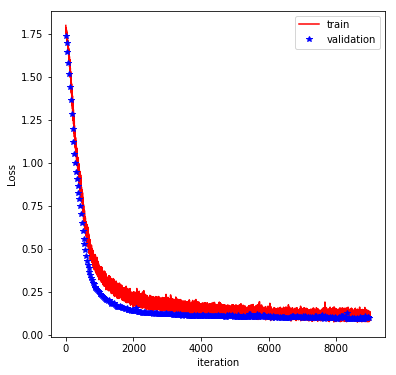

In [14]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 25 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

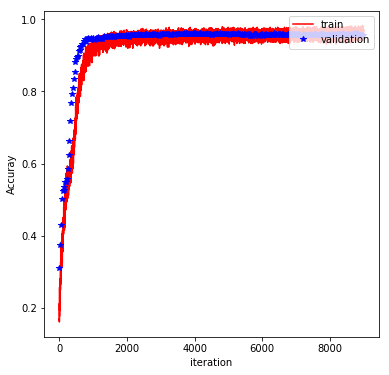

In [15]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 25 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [16]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-crnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))  # Test accuracy: 0.905417

INFO:tensorflow:Restoring parameters from checkpoints-crnn/har.ckpt
Test accuracy: 0.905417
